In [1]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, b_i = three()  # 输入门参数
    W_xf, W_hf, b_f = three()  # 遗忘门参数
    W_xo, W_ho, b_o = three()  # 输出门参数
    W_xc, W_hc, b_c = three()  # 候选记忆元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [3]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [4]:
def lstm(inputs, state, params):
    [W_xi, W_hi, b_i, W_xf, W_hf, b_f, W_xo, W_ho, b_o, W_xc, W_hc, b_c,
     W_hq, b_q] = params
    (H, C) = state
    outputs = []
    for X in inputs:
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

In [5]:
import matplotlib.pyplot as plt

def train_ch8(model, train_iter, vocab, lr, num_epochs, device,
                   use_random_iter=False):
    # 创建两个列表跟踪每个epoch的困惑度 用于绘图
    epochs = []
    ppls = []

    # 使用交叉熵损失进行处理
    loss = nn.CrossEntropyLoss()

    # 初始化优化器
    if isinstance(model, nn.Module):
        # PyTorch模型：使用标准SGD优化器
        updater = torch.optim.SGD(model.parameters(), lr)
    else:
        # 自定义模型：使用函数式SGD实现
        updater = lambda batch_size: d2l.sgd(model.params, lr, batch_size)

    # 预测函数
    def predict(prefix):
        return d2l.predict_ch8(prefix, 50, model, vocab, device)

    # 训练循环
    for epoch in range(num_epochs):
        ppl, speed = d2l.train_epoch_ch8(
            model, train_iter, loss, updater, device, use_random_iter)
        # 更新列表中的轮次以及困惑度
        epochs.append(epoch + 1)
        ppls.append(ppl)

    # 训练完成后打印最终结果
    print(f'训练完成。最终困惑度: {ppl:.2f}, 速度: {speed:.1f} tokens/sec on {str(device)}')
    print('生成文本示例:')
    print(predict('time traveller'))

    # 训练完成后绘制困惑度曲线
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, ppls, 'b-', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

训练完成。最终困惑度: 1.12, 速度: 100596.8 tokens/sec on cuda:0
生成文本示例:
time traveller for so it will be convenient to speak of himwas e


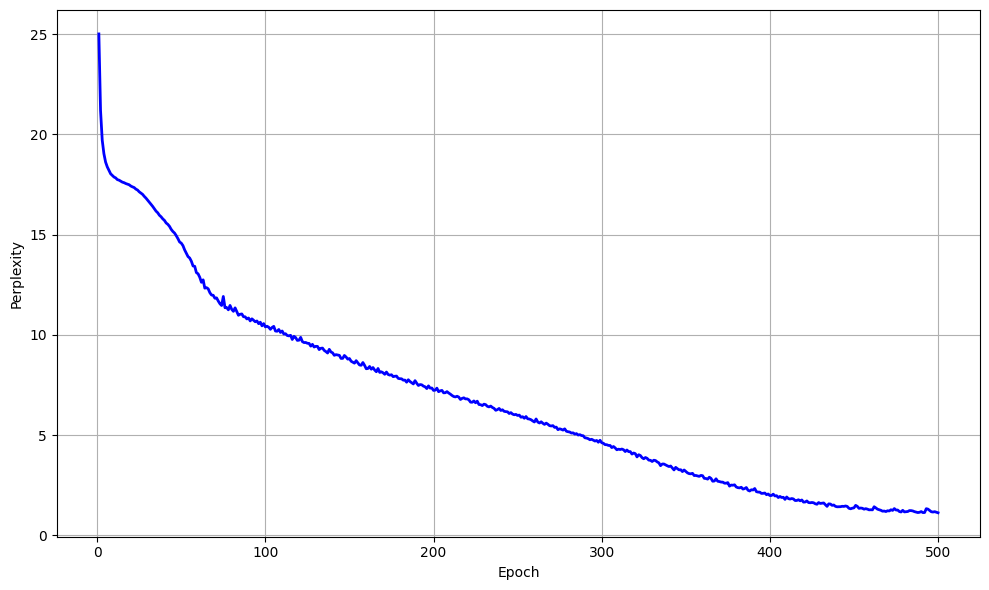

In [7]:
vocab_size, num_hiddens, device = len(vocab), 256, d2l.try_gpu()
num_epochs, lr = 500, 1
model = d2l.RNNModelScratch(len(vocab), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

训练完成。最终困惑度: 1.05, 速度: 1041052.8 tokens/sec on cuda:0
生成文本示例:
time traveller for so it will be convenient to speak of himwas e


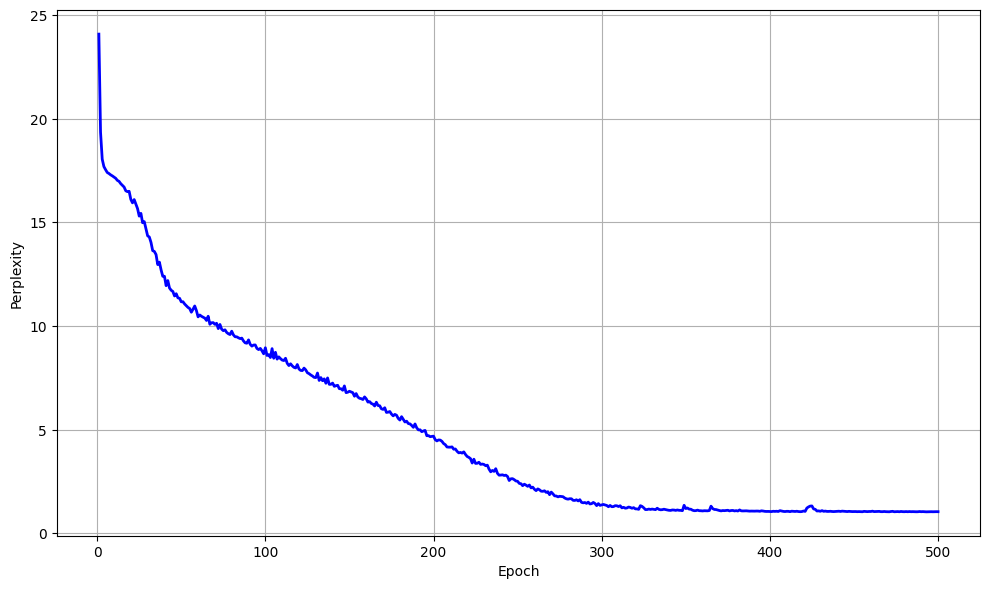

In [8]:
# 高级实现
num_inputs = vocab_size
lstm_layer = nn.LSTM(num_inputs, num_hiddens)
model = d2l.RNNModel(lstm_layer, len(vocab))
model = model.to(device)
train_ch8(model, train_iter, vocab, lr, num_epochs, device)

# LSTM 计算过程详解及参数意义与作用

本文详细解析 LSTM（长短期记忆网络）的核心计算公式、数据流以及各个参数的意义与作用，帮助理解其在长序列数据处理中的优势。

---

## 参数上下文
假设以下参数：
- **`batch_size`**: `32`
- **`num_steps`**: `35` （时间步数）
- **`input_size`**: `28` （输入特征维度）
- **`hidden_size`**: `256` （隐藏状态 $H_t$ 和记忆单元 $C_t$ 的特征维度）
- **`output_size`**: `28$ （最终输出 $Y_t$ 的特征维度）

---

## LSTM 的核心公式与计算过程

### 1. 输入门 ($i_t$)
公式：
$$
i_t = \sigma(X_t W_{xi} + H_{t-1} W_{hi} + b_i)
$$

#### 意义
输入门决定了当前时间步的候选记忆单元 $\tilde{C}_t$ 中有多少信息可以写入到当前的记忆单元 $C_t$。

#### 作用
- 控制当前输入 $X_t$ 的重要程度。
- 类似于“允许输入”的开关。

#### 计算过程
- $X_t W_{xi}$: 输入 $X_t$ 的形状为 $[32, 28]$，权重 $W_{xi}$ 的形状为 $[28, 256]$，结果为 $[32, 256]$。
- $H_{t-1} W_{hi}$: 隐状态 $H_{t-1}$ 的形状为 $[32, 256]$，权重 $W_{hi}$ 的形状为 $[256, 256]$，结果为 $[32, 256]$。
- 偏置 $b_i$: 形状为 $[256]$，通过广播与上述结果相加。
- **最终 $i_t$ 的形状**: $[32, 256]$。

---

### 2. 遗忘门 ($f_t$)
公式：
$$
f_t = \sigma(X_t W_{xf} + H_{t-1} W_{hf} + b_f)
$$

#### 意义
遗忘门决定了上一个记忆单元 $C_{t-1}$ 中哪些信息需要被遗忘（丢弃）。

#### 作用
- 控制前一时间步的记忆单元 $C_{t-1}$ 的保留比例。
- 遗忘门的设计是解决梯度消失问题的关键，确保模型能够“记住”重要的历史信息而非全部保留。

#### 计算过程
- $X_t W_{xf}$: 输入 $X_t$ 的形状为 $[32, 28]$，权重 $W_{xf}$ 的形状为 $[28, 256]$，结果为 $[32, 256]$。
- $H_{t-1} W_{hf}$: 隐状态 $H_{t-1}$ 的形状为 $[32, 256]$，权重 $W_{hf}$ 的形状为 $[256, 256]$，结果为 $[32, 256]$。
- 偏置 $b_f$: 形状为 $[256]$，通过广播与上述结果相加。
- **最终 $f_t$ 的形状**: $[32, 256]$。

---

### 3. 候选记忆单元 ($\tilde{C}_t$)
公式：
$$
\tilde{C}_t = \tanh(X_t W_{xc} + H_{t-1} W_{hc} + b_c)
$$

#### 意义
候选记忆单元是当前时间步用于更新记忆单元 $C_t$ 的新信息。

#### 作用
- 提供当前时间步的潜在记忆信息。
- 通过输入门 $i_t$ 控制其写入比例。

#### 计算过程
- $X_t W_{xc}$: 输入 $X_t$ 的形状为 $[32, 28]$，权重 $W_{xc}$ 的形状为 $[28, 256]$，结果为 $[32, 256]$。
- $H_{t-1} W_{hc}$: 隐状态 $H_{t-1}$ 的形状为 $[32, 256]$，权重 $W_{hc}$ 的形状为 $[256, 256]$，结果为 $[32, 256]$。
- 偏置 $b_c$: 形状为 $[256]$，通过广播与上述结果相加。
- **最终 $\tilde{C}_t$ 的形状**: $[32, 256]$。

---

### 4. 记忆单元更新 ($C_t$)
公式：
$$
C_t = f_t \odot C_{t-1} + i_t \odot \tilde{C}_t
$$

#### 意义
记忆单元是 LSTM 的内部核心状态，用于存储长期依赖信息。

#### 作用
- 综合遗忘门 $f_t$ 和输入门 $i_t$ 的作用，对前一时间步记忆 $C_{t-1}$ 和当前候选记忆 $\tilde{C}_t$ 进行加权更新。
- $C_t$ 是整个 LSTM 网络的长期记忆存储。

#### 计算过程
- $f_t \odot C_{t-1}$: 遗忘门 $f_t$ 和前一时间步记忆单元 $C_{t-1}$ 按元素相乘，形状为 $[32, 256]$。
- $i_t \odot \tilde{C}_t$: 输入门 $i_t$ 和候选记忆单元 $\tilde{C}_t$ 按元素相乘，形状为 $[32, 256]$。
- **最终 $C_t$ 的形状**: $[32, 256]$。

---

### 5. 输出门 ($o_t$)
公式：
$$
o_t = \sigma(X_t W_{xo} + H_{t-1} W_{ho} + b_o)
$$

#### 意义
输出门决定了当前时间步的记忆单元 $C_t$ 中哪些信息需要输出（映射到隐藏状态 $H_t$）。

#### 作用
- 控制记忆单元 $C_t$ 的输出比例。
- 决定当前时间步的隐藏状态 $H_t$。

#### 计算过程
- $X_t W_{xo}$: 输入 $X_t$ 的形状为 $[32, 28]$，权重 $W_{xo}$ 的形状为 $[28, 256]$，结果为 $[32, 256]$。
- $H_{t-1} W_{ho}$: 隐状态 $H_{t-1}$ 的形状为 $[32, 256]$，权重 $W_{ho}$ 的形状为 $[256, 256]$，结果为 $[32, 256]$。
- 偏置 $b_o$: 形状为 $[256]$，通过广播与上述结果相加。
- **最终 $o_t$ 的形状**: $[32, 256]$。

---

### 6. 隐状态更新 ($H_t$)
公式：
$$
H_t = o_t \odot \tanh(C_t)
$$

#### 意义
隐藏状态是当前时间步的输出，同时也作为下一时间步的输入。

#### 作用
- 提供当前时间步的输出信息。
- 连接时间步之间的信息流动。

#### 计算过程
- $\tanh(C_t)$: 对记忆单元 $C_t$ 应用 $\tanh$ 激活函数，形状为 $[32, 256]$。
- $o_t \odot \tanh(C_t)$: 输出门 $o_t$ 和 $\tanh(C_t)$ 按元素相乘，形状为 $[32, 256]$。
- **最终 $H_t$ 的形状**: $[32, 256]$。

---

### 7. 输出 ($Y_t$)
公式：
$$
Y_t = H_t W_{hq} + b_q
$$

#### 计算过程
- $H_t W_{hq}$: 隐状态 $H_t$ 的形状为 $[32, 256]$，权重 $W_{hq}$ 的形状为 $[256, 28]$，结果为 $[32, 28]$。
- 偏置 $b_q$: 形状为 $[28]$，通过广播与上述结果相加。
- **最终 $Y_t$ 的形状**: $[32, 28]$。